In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# # Autoformat code
# # Run the whole cell, then refresh the notebook
# !pip install -U nbqa black isort mdformat
# !python -m nbqa black "/content/gdrive/Shareddrives/Fleischmann Lab Group/Researchers/Olivia McKissick/For_AP/three subplots_daily.ipynb"
# !python -m nbqa isort "/content/gdrive/Shareddrives/Fleischmann Lab Group/Researchers/Olivia McKissick/For_AP/three subplots_daily.ipynb"
# !python -m nbqa mdformat "/content/gdrive/Shareddrives/Fleischmann Lab Group/Researchers/Olivia McKissick/For_AP/three subplots_daily.ipynb" --nbqa-md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 11.9 MB/s 
     |████████████████████████████████| 103 kB 66.7 MB/s 
     |████████████████████████████████| 1.6 MB 33.1 MB/s 
     |████████████████████████████████| 843 kB 58.7 MB/s 
     |████████████████████████████████| 96 kB 6.7 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.
All done! ✨ 🍰 ✨
1 file left unchanged.
Fixing /content/gdrive/Shareddrives/Fleischmann Lab Group/Researchers/Olivia McKissick/For_AP/three subplots_

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set()
import csv
import os
import re
from pathlib import Path

import pandas as pd
from IPython.core.pylabtools import figsize
from tqdm import tqdm

In [ ]:
# you probably want to change these variables each time
cohort = "E_"
day = "d80"
# path= '/content/gdrive/My Drive/backup/cam21-25_analyzed/cam2_/d15/'
path = Path(
    "/content/gdrive/Shareddrives/Fleischmann Lab Group/Researchers/Olivia McKissick/For_AP/"
).joinpath(cohort, day)

In [ ]:
def do_it_all(file):
    df = pd.read_csv(path + os.sep + file)
    name, ext = os.path.splitext(file)
    # convert timestamps to seconds
    starttime = df.iloc[0]["Time"]
    df = df.apply(lambda x: x - starttime if x.name in ["Time"] else x)
    #
    with open(path + "output_" + cohort + day + ".csv", "a") as file:
        # record total num of "correct" pokes
        re_N, re_S, re_E, re_W = (
            (df["reN"].sum()),
            (df["reS"].sum()),
            (df["reE"].sum()),
            (df["reW"].sum()),
        )
        trial_num = re_N + re_S
        # this was 0:3 for recent cohorts.. change to reflect how many letters r in each mouse ID (from the filename):
        # 0:3 means it uses the first 3 characters
        nom = name[0:3]
        # get the phase:
        # from filename
        pattern = "p(.*?)_"
        phase = re.search(pattern, name).group(1)

        # to find individual poke starts and then see how many reE or reW follow reN or reS immediately
        df6 = df.loc[
            (df["N"] > df["N"].shift())
            | (df["S"] > df["S"].shift())
            | (df["E"] > df["E"].shift())
            | (df["W"] > df["W"].shift())
            | (df["reN"] == 1)
            | (df["reS"] == 1)
        ]
        df6.reset_index(drop=True, inplace=True)

        rowx = pd.DataFrame(
            [[0] * df.shape[1]], columns=df.columns
        )  # adds row at the end incase the last record is reN or reS? only to df6 so doesnt change trial num or anything
        df7 = df6.append(rowx, ignore_index=True)

        dfinit = df7.index[(df7["reN"] == 1) | (df7["reS"] == 1)]
        nextcheck = []
        for val in dfinit:
            next = val + 1
            nextcheck.append(next)
        print(nextcheck)
        isitcorrect = df7.iloc[nextcheck]
        realreEs = isitcorrect["reE"].sum()
        realreWs = isitcorrect["reW"].sum()
        correct = realreEs + realreWs
        percent = (correct / trial_num) * 100
        ##MAKE A PHASE
        timebtwpokes = df6["Time"].diff().mean()
        allpokes = len(df6.index)
        allN = df6["N"].sum()
        allS = df6["S"].sum()
        allE = df6["E"].sum()
        allW = df6["W"].sum()

        listo = [
            nom,
            cohort,
            day,
            phase,
            percent,
            timebtwpokes,
            trial_num,
            correct,
            allpokes,
            re_N,
            re_S,
            re_E,
            re_W,
            allN,
            allS,
            allE,
            allW,
        ]
        fine = csv.writer(file)
        fine.writerow(listo)

In [ ]:
def fig1(file, ax):
    pd.options.mode.chained_assignment = None  # default='warn'
    df = pd.read_csv(path + os.sep + file)  # read in that original file
    name, ext = os.path.splitext(file)
    starttime = df.iloc[0]["Time"]
    df = df.apply(lambda x: x - starttime if x.name in ["Time"] else x)

    sns.set(style="whitegrid")

    # df6 is the start of each poke ...
    df6 = df.loc[
        (df["N"] > df["N"].shift())
        | (df["S"] > df["S"].shift())
        | (df["E"] > df["E"].shift())
        | (df["W"] > df["W"].shift())
        | (df["reN"] == 1)
        | (df["reS"] == 1)
    ]
    # df is all recorded pokes
    df6.loc[(df["N"] > df["N"].shift()), "pokecat"] = "N"
    df6.loc[(df["S"] > df["S"].shift()), "pokecat"] = "S"
    df6.loc[(df["E"] > df["E"].shift()), "pokecat"] = "E"
    df6.loc[(df["W"] > df["W"].shift()), "pokecat"] = "W"
    df6.loc[(df["reN"] == 1), "reNScat"] = "N"  # gold
    df6.loc[(df["reS"] == 1), "reNScat"] = "S"  # gold
    df6.loc[(df["reE"] == 1), "reEWcat"] = "E"  # aqua
    df6.loc[(df["reW"] == 1), "reEWcat"] = "W"  # aqua
    # little side quest to make sure there's an extra row at the end (for nextcheck situation)
    rowx = pd.DataFrame([[0] * df.shape[1]], columns=df.columns)
    df = df.append(rowx, ignore_index=True)
    # adding a col "pokecat" to df that labels the start of each poke using index

    # make another column to label poke durations
    dfallN, dfallS, dfallE, dfallW = (
        df.index[(df["N"] == 1)],
        df.index[(df["S"] == 1)],
        df.index[(df["E"] == 1)],
        df.index[(df["W"] == 1)],
    )

    df.loc[dfallN, "allcat"] = "N"
    df.loc[dfallS, "allcat"] = "S"
    df.loc[dfallE, "allcat"] = "E"
    df.loc[dfallW, "allcat"] = "W"

    # find dfreN and dfreS that are immediately followed by either reE or re
    df6["phase"] = pd.Categorical(
        df6["phase"], categories=["True", "False"], ordered=True
    )
    df6["pokecat"] = pd.Categorical(
        df6["pokecat"], categories=["N", "S", "E", "W"], ordered=True
    )
    df["allcat"] = pd.Categorical(
        df["allcat"], categories=["N", "S", "E", "W"], ordered=True
    )
    df6["reNScat"] = pd.Categorical(
        df6["reNScat"], categories=["N", "S", "E", "W"], ordered=True
    )
    df6["reEWcat"] = pd.Categorical(
        df6["reEWcat"], categories=["N", "S", "E", "W"], ordered=True
    )
    # df6['rerecat'] = pd.Categorical(df6['rerecat'],categories=['N', 'S', 'E', 'W'], ordered=True) ##this guy's gonna do the starring fix later

    # ready the data -- do i need to transpose seems crazy
    N = np.transpose(df["N"].to_numpy())
    S = np.transpose(df["S"].to_numpy())
    E = np.transpose(df["E"].to_numpy())
    W = np.transpose(df["W"].to_numpy())

    reN = np.transpose(df["reN"].to_numpy())
    reS = np.transpose(df["reS"].to_numpy())
    reE = np.transpose(df["reE"].to_numpy())
    reW = np.transpose(df["reW"].to_numpy())
    # y=(df6['rerecat'])
    y1 = df6["pokecat"]
    x = np.transpose(df["Time"].to_numpy())
    y2 = df6["reEWcat"]
    plt.rcParams["figure.dpi"] = 300
    plt.rcParams["savefig.dpi"] = 300

    sns.set(style="whitegrid")
    ax.set(xlabel="time in sec", ylabel="ports", title=("all pokes_" + name))

    # plt.xlim(0,45*60)
    # think about adding ylim
    # plt.xticks(np.arange(0, 45*60,120))
    # plt.title('all pokes'+ name)
    # plt.ylabel('pokes at each port')
    # plt.xlabel('time in secs')

    # plt.figure(figsize=(20,2.5))
    # sns.scatterplot(x='Time',y='phase',data=df6, s=5000,hue='phase', marker='o',legend='auto',alpha=0.1,ax=ax)  #formerly recat

    sns.scatterplot(
        x="Time",
        y="reEWcat",
        data=df6,
        s=200,
        color="cyan",
        marker="o",
        legend="auto",
        ax=ax,
    )  # formerly recat
    sns.scatterplot(
        x="Time",
        y="reNScat",
        data=df6,
        s=200,
        color="gold",
        marker="o",
        legend="auto",
        ax=ax,
    )  # change to gold #formerly recatcat

    sns.scatterplot(
        x="Time",
        y="allcat",
        data=df,
        hue="allcat",
        legend=False,
        alpha=0.3,
        edgecolor="face",
        ax=ax,
    )  # every poke
    sns.lineplot(
        x="Time", y="allcat", data=df, legend=False, alpha=0.3, ax=ax
    )  # poke initiations
    sns.scatterplot(
        x="Time", y="pokecat", data=df6, hue="pokecat", legend=True, ax=ax
    )  # poke initiations

    plt.legend(["N", "S", "E", "W"], loc="upper right")

    # plt.savefig(path+'POKESwcorrect_'+name+'.png', dpi = 300)

    # print(df6)

In [ ]:
def figtdelay(file, ax):
    pd.options.mode.chained_assignment = None  # default='warn'
    df = pd.read_csv(path + os.sep + file)  # read in that original file
    name, ext = os.path.splitext(file)
    starttime = df.iloc[0]["Time"]
    df = df.apply(lambda x: x - starttime if x.name in ["Time"] else x)
    df6 = df.loc[
        (df["N"] > df["N"].shift())
        | (df["S"] > df["S"].shift())
        | (df["E"] > df["E"].shift())
        | (df["W"] > df["W"].shift())
        | (df["reN"] == 1)
        | (df["reS"] == 1)
    ]

    # df777 = df6['Time','reEWcat']
    # df7=df777.copy()
    # df7=df6.loc[df6['Time'],'Time']

    sns.set(style="whitegrid")
    ax.set(xlabel="time in sec", ylabel="tdelay", title=("tdelay_" + name))

    #  plt.figure(figsize=(20,2.5))
    #  plt.xlim(0,45*60)
    #  plt.ylim(0,1.0)
    # plt.xticks(np.arange(0, 45*60,120))
    #  plt.title('tdelay_'+ name)
    # plt.ylabel('tdelay')
    # plt.xlabel('time in secs')
    sns.lineplot(
        x="Time", y="tdelay", data=df6, legend=False, ax=ax
    )  # poke initiations
    # print(df6)
    # plt.savefig(path+'tdelay'+name+'.png', dpi = 300)

In [ ]:
def figrew(file, ax):
    pd.options.mode.chained_assignment = None  # default='warn'
    df = pd.read_csv(path + os.sep + file)  # read in that original file
    name, ext = os.path.splitext(file)
    starttime = df.iloc[0]["Time"]
    df = df.apply(lambda x: x - starttime if x.name in ["Time"] else x)

    df6 = df.loc[
        (df["N"] > df["N"].shift())
        | (df["S"] > df["S"].shift())
        | (df["E"] > df["E"].shift())
        | (df["W"] > df["W"].shift())
        | (df["reN"] == 1)
        | (df["reS"] == 1)
    ]

    df6.loc[(df6["reE"] == 1), "reEWcat"] = 1
    df6.loc[(df6["reW"] == 1), "reEWcat"] = 1
    df6.iat[-1, -1] = 0
    df6.iat[0, -1] = 0
    # df7 = df6['Time','reEWcat'].copy()
    # df7=df6.loc[df6['Time'],'Time']
    y = df6["reEWcat"].cumsum()
    sns.set(style="whitegrid")
    ax.set(ylabel="reward num", title=("reward accumulation_" + name))
    # plt.figure(figsize=(20,2.5))
    # plt.xlim(0,45*60)
    # plt.ylim(0,75)

    # sns.ecdfplot(x='Time',data=df7,legend=False,alpha=0.3) #poke initiations
    # plt.xticks(np.arange(0, 45*60,120))
    # plt.title('reward_accumulation_'+ name)
    # plt.ylabel('number of 1 sec rewards')
    # plt.xlabel('time in secs')

    sns.lineplot(
        x="Time", y=y, data=df6, legend=False, drawstyle="steps-post", ax=ax
    )  # poke initiations

    # plt.savefig(path+'rewards_'+name+'.png', dpi = 300)

    # print(df6)
    # print(y)

  0%|          | 0/4 [00:00<?, ?it/s]


Found file: E02_d80p2A_30.Aug.22_16.19_PHASE1.csv
[7, 11, 14, 17, 21, 26, 30, 35, 38, 41, 45, 49, 54, 58, 61, 64, 67, 71, 74, 79, 82, 85, 88, 91, 94, 97, 100, 103, 106, 109, 112, 115, 118, 121, 126, 129, 132, 135, 144, 147, 150, 155, 158, 161, 164, 169, 172, 178, 183, 186, 189, 194, 197, 200, 204, 207, 210, 216, 221, 226, 229, 234, 237, 241, 244, 248, 251, 259, 263, 266, 269, 276, 288, 291, 294, 297, 302, 305]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
 25%|██▌       | 1/4 [19:22<58:07, 1162.63s/it]


Found file: E01_d80p2A_30.Aug.22_15.28_PHASE1.csv
[7, 15, 18, 25, 29, 33, 36, 39, 43, 46, 49, 54, 59, 62, 66, 71, 75, 79, 82, 87, 90, 93, 98, 102, 106, 111, 114, 117, 121, 124, 127, 130, 134, 142, 145, 153, 156, 160, 165, 170, 174, 177, 181, 184, 189, 192, 195, 198, 201, 208, 214, 219, 223]


 50%|█████     | 2/4 [35:16<34:39, 1039.79s/it]


Found file: E03_d80p2A_30.Aug.22_17.09_PHASE1.csv
[12, 16, 20, 24, 32, 39, 43, 48, 51, 56, 61, 66, 72, 75, 81, 87, 90, 93, 96, 103, 109, 112, 116, 119, 122, 132, 135, 140, 143, 146, 150, 156, 159, 164, 168, 174, 179, 186, 189, 194, 197, 200, 203, 206, 212, 216, 220, 228, 237, 257, 269]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
 75%|███████▌  | 3/4 [54:50<18:21, 1101.24s/it]


Found file: E04_d80p2A_30.Aug.22_17.59_PHASE1.csv
[6, 10, 13, 18, 23, 26, 29, 34, 37, 40, 43, 48, 51, 55, 58, 61, 64, 69, 73, 76, 79, 82, 85, 91, 96, 99, 102, 105, 108, 113, 116, 119, 122, 126, 130, 139, 142, 148, 152, 158, 164]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
100%|██████████| 4/4 [1:21:27<00:00, 1221.89s/it]


<Figure size 2500x1000 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


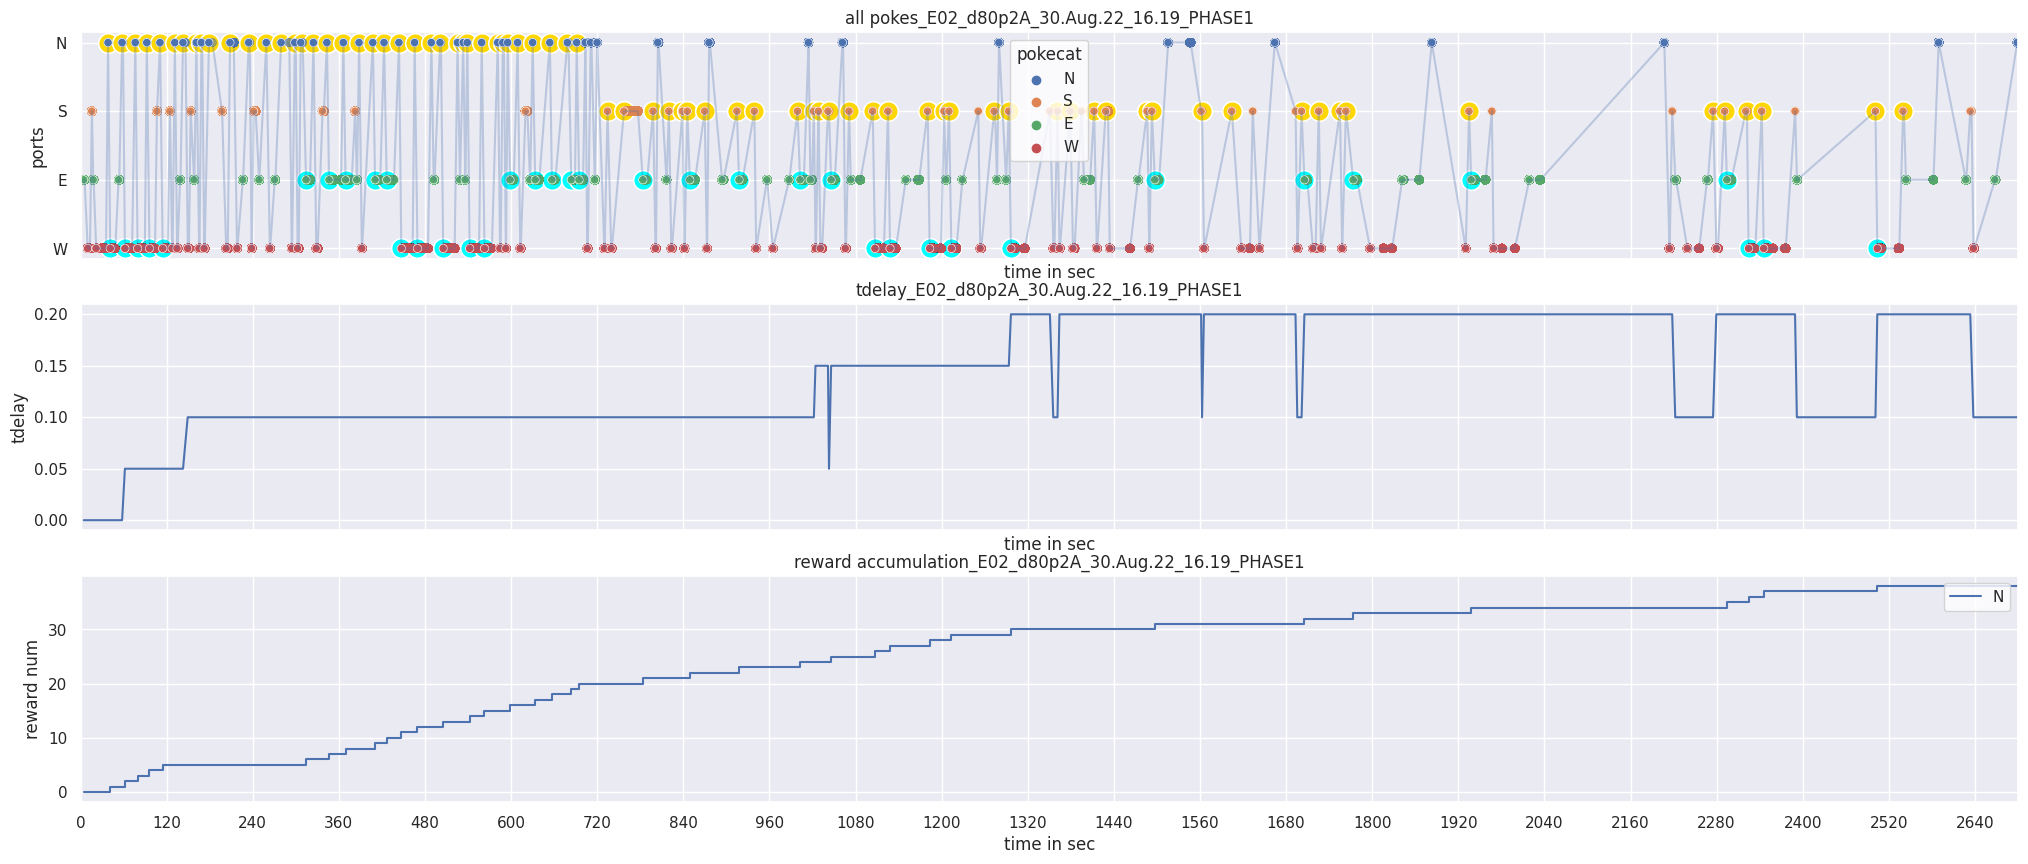

<Figure size 7500x3000 with 0 Axes>

In [ ]:
for path, folder, files in os.walk(path):
    for file in tqdm(files):
        if file.endswith("E1.csv"):
            print(f"\nFound file: {file}")
            name, ext = os.path.splitext(file)
            base = os.path.basename(path)
            do_it_all(file)
            plt.figure(figsize=(25, 10))

            fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(25, 10), sharex=True)

            fig1(file, axes[0])
            figtdelay(file, axes[1])
            figrew(file, axes[2])
            plt.xlabel("time in sec")
            plt.legend(
                ["N", "S", "E", "W"],
                loc="upper right",
            )
            plt.xlim(0, 45 * 60)
            plt.xticks(np.arange(0, 45 * 60, 120))
            plt.savefig(path + "3plots_" + name + ".png", dpi=300)

        # fig2(file)
        # testo(file)

# print(name)
plt.show()